In [179]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score
!pip install kneed
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering, KMeans

In [180]:
import pandas as pd

url = "https://raw.githubusercontent.com/bsantosa01/Data-Mining---ALP---Group-13---Brant-Marvel-Santosa/refs/heads/main/Capstone1C_EuroMart%20Stores-1.csv"
df = pd.read_csv(url)
df.head()


,Order ID,Order Date,Customer Name,Country,State,City,Region,Segment,Ship Mode,Category,Sub-Category,Product Name,Discount,Sales,Profit,Quantity,Feedback?
0,BN-2011-7407039,1/1/2011,Ruby Patel,Sweden,Stockholm,Stockholm,North,Home Office,Economy Plus,Office Supplies,Paper,"Enermax Note Cards, Premium",$0.5,$45,$-26,3,False
1,AZ-2011-9050313,1/3/2011,Summer Hayward,United Kingdom,England,Southport,North,Consumer,Economy,Furniture,Bookcases,"Dania Corner Shelving, Traditional",$-,$854,$290,7,True
2,AZ-2011-6674300,1/4/2011,Devin Huddleston,France,Auvergne-Rhône-Alpes,Valence,Central,Consumer,Economy,Office Supplies,Art,"Binney & Smith Sketch Pad, Easy-Erase",$-,$140,$21,3,True
3,BN-2011-2819714,1/4/2011,Mary Parker,United Kingdom,England,Birmingham,North,Corporate,Economy,Office Supplies,Art,"Boston Markers, Easy-Erase",$0.5,$27,$-22,2,True
4,BN-2011-2819714,1/4/2011,Mary Parker,United Kingdom,England,Birmingham,North,Corporate,Economy,Office Supplies,Storage,"Eldon Folders, Single Width",$0.5,$17,$-1,2,True


Kode ini memuat dataset retail dari github saya ke dalam Python agar dapat dianalisis lebih lanjut. Dengan menggunakan tautan ini, data dapat diakses secara online tanpa perlu mengunggah file secara manual, sehingga memudahkan analisis terutama saat menggunakan platform seperti Google Colab.

Kode ini membaca file CSV dan menyimpannya ke dalam sebuah DataFrame bernama df. DataFrame adalah struktur data berbentuk tabel yang memudahkan proses manipulasi dan analisis data. Perintah df.head() menampilkan lima baris pertama dari dataset, sehingga kita dapat melihat struktur data, nama kolom, serta contoh nilai yang ada.

In [181]:
df.columns = df.columns.str.strip()

Kode ini digunakan untuk membersihkan nama kolom pada dataset dengan menghapus spasi berlebih di awal dan akhir nama kolom. Spasi tersembunyi pada nama kolom sering kali menyebabkan error saat pemanggilan kolom, terutama ketika melakukan analisis data atau pemrosesan lanjutan.

In [182]:
cols = ['Discount', 'Sales', 'Profit']

for col in cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace('$', '', regex=False)
        .str.replace(',', '', regex=False)
        .str.strip()
    )

    # Convert to numeric safely
    df[col] = pd.to_numeric(df[col], errors='coerce')


Kode ini digunakan untuk membersihkan dan mengubah kolom Discount, Sales, dan Profit menjadi data numerik agar dapat digunakan dalam proses analisis dan clustering. Pada dataset awal, ketiga kolom tersebut masih bertipe object karena mengandung simbol seperti tanda dolar ($), tanda koma, dan spasi.

Data diubah menjadi tipe string agar proses pembersihan berjalan konsisten. Selanjutnya, simbol dolar dan tanda koma dihapus, serta spasi yang tidak diperlukan dibersihkan. Setelah itu, data dikonversi ke tipe numerik menggunakan. Jika terdapat nilai yang tidak dapat dikonversi (misalnya data kosong atau tidak valid), maka nilai tersebut akan otomatis diubah menjadi NaN.

# Visualization

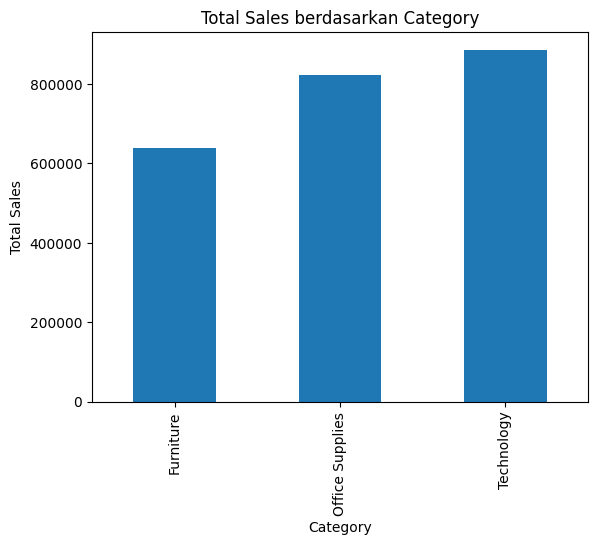

In [183]:
import matplotlib.pyplot as plt

category_sales = df.groupby('Category')['Sales'].sum()
category_sales.plot(kind='bar')
plt.title("Total Sales berdasarkan Category")
plt.xlabel("Category")
plt.ylabel("Total Sales")
plt.show()

Visualisasi ini menunjukkan total nilai penjualan untuk setiap kategori produk. Perbedaan tinggi batang mengindikasikan bahwa tidak semua kategori memberikan kontribusi penjualan yang sama. Kategori dengan total sales tertinggi dapat dianggap sebagai kategori unggulan yang memiliki permintaan pasar paling besar.

<Figure size 800x500 with 0 Axes>

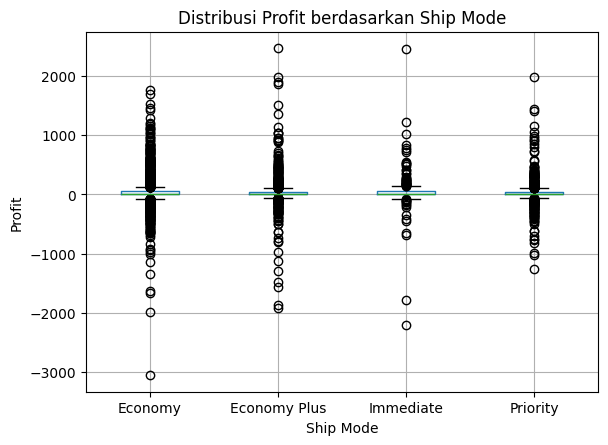

In [184]:
plt.figure(figsize=(8,5))
df.boxplot(column='Profit', by='Ship Mode')
plt.title("Distribusi Profit berdasarkan Ship Mode")
plt.suptitle("")
plt.xlabel("Ship Mode")
plt.ylabel("Profit")
plt.show()


Boxplot ini memperlihatkan distribusi profit untuk setiap metode pengiriman. Terlihat adanya perbedaan median dan sebaran profit antar ship mode, yang menunjukkan bahwa pilihan metode pengiriman dapat memengaruhi tingkat keuntungan. Beberapa ship mode menghasilkan profit yang lebih stabil, sementara yang lain memiliki variasi profit yang lebih besar.

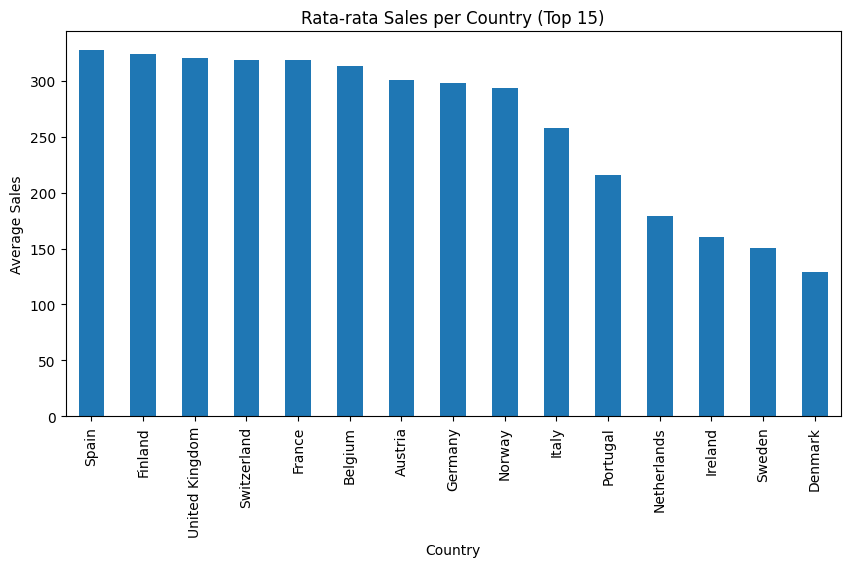

In [185]:
country_sales = df.groupby('Country')['Sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
country_sales.head(15).plot(kind='bar')
plt.title("Rata-rata Sales per Country (Top 15)")
plt.xlabel("Country")
plt.ylabel("Average Sales")
plt.show()


Visualisasi ini menampilkan 15 negara dengan rata-rata nilai penjualan tertinggi. Hasil ini menunjukkan bahwa terdapat perbedaan signifikan performa penjualan antar negara. Informasi ini sangat penting dalam analisis clustering karena negara dengan pola penjualan yang mirip cenderung berada dalam cluster yang sama.

# Data Preparation

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       8047 non-null   object 
 1   Order Date     8047 non-null   object 
 2   Customer Name  8047 non-null   object 
 3   Country        8047 non-null   object 
 4   State          8047 non-null   object 
 5   City           8047 non-null   object 
 6   Region         8047 non-null   object 
 7   Segment        8047 non-null   object 
 8   Ship Mode      8047 non-null   object 
 9   Category       8047 non-null   object 
 10  Sub-Category   8047 non-null   object 
 11  Product Name   8047 non-null   object 
 12  Discount       3138 non-null   float64
 13  Sales          8047 non-null   int64  
 14  Profit         7815 non-null   float64
 15  Quantity       8047 non-null   int64  
 16  Feedback?      8047 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(12)
memory 

Hasil menunjukkan bahwa tidak semua kolom memiliki data yang lengkap. Kolom Discount hanya memiliki 3.138 data yang terisi, sedangkan kolom Profit memiliki 7.815 data yang terisi dari total 8.047 baris. Hal ini menandakan adanya nilai kosong (missing values) pada kedua kolom tersebut.

In [187]:
df.isna().sum()

,0
Order ID,0
Order Date,0
Customer Name,0
Country,0
State,0
City,0
Region,0
Segment,0
Ship Mode,0
Category,0


Code ini menghitung jumlah nilai kosong (missing values) pada setiap kolom dalam dataset, dan sebagian besar kolom tidak memiliki nilai kosong. Namun, terdapat dua kolom yang memiliki nilai kosong, yaitu kolom Discount dengan 4.909 data kosong dan kolom Profit dengan 232 data kosong. Missing values ini harus ditangani karena akan memengaruhi proses analisis dan hasil clustering.

In [188]:
df.describe()

,Discount,Sales,Profit,Quantity
count,3138.000000,8047.000000,7815.000000,8047.000000
mean,0.287635,291.845657,36.243122,3.772089
std,0.188293,485.212156,180.646003,2.203369
min,0.100000,3.000000,-3060.000000,1.000000
25%,0.100000,48.000000,2.000000,2.000000
50%,0.200000,117.000000,15.000000,3.000000
75%,0.500000,313.000000,49.000000,5.000000
max,0.900000,6517.000000,2476.000000,14.000000


Saya menggunakan fungsi describe() untuk melihat statistik deskriptif dari dataset.
Dari sini saya bisa mengetahui nilai rata-rata, minimum, maksimum, dan sebaran data, sehingga membantu memahami kondisi awal data sebelum dilakukan clustering.

In [189]:
# Drop unused column
df = df.drop(columns=['Order ID'], errors='ignore')
df = df.drop(columns=['Customer Name'], errors='ignore')
df = df.drop(columns=['Order Date'], errors='ignore')

Kode ini digunakan untuk menghapus kolom-kolom yang tidak diperlukan dalam proses analisis dan clustering. Kolom Order ID, Customer Name, dan Order Date dihapus karena kolom-kolom tersebut bersifat identitas atau informasi administratif, bukan variabel numerik atau karakteristik perilaku yang relevan untuk pembentukan cluster.

In [190]:
df['Discount'] = df['Discount'].fillna(0)

Kode ini digunakan untuk menangani nilai kosong (missing values) pada kolom Discount. Pengisian nilai kosong dengan 0 dilakukan karena pada konteks data penjualan, nilai Discount yang kosong dapat diasumsikan sebagai tidak ada diskon pada transaksi tersebut. Langkah ini penting agar kolom Discount dapat digunakan dalam proses analisis dan clustering tanpa menyebabkan error.

In [191]:
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')

df['Profit'].fillna(df['Profit'].median(), inplace=True)


/tmp/ipython-input-3346252511.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Kode ini digunakan untuk membersihkan dan menangani nilai kosong pada kolom Profit agar data siap digunakan dalam analisis lanjutan.

Baris pertama memastikan bahwa kolom Profit bertipe numerik dengan menggunakan pd.to_numeric(). Jika terdapat nilai yang tidak bisa dikonversi menjadi angka, nilai tersebut akan diubah menjadi NaN (errors='coerce'). Selanjutnya, nilai NaN pada kolom Profit diisi menggunakan nilai median dari kolom tersebut. Penggunaan median dipilih karena lebih stabil terhadap nilai ekstrem (outlier) dibandingkan rata-rata.

In [192]:
import pycountry

def get_iso3(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except:
        return None

df['ISO3'] = df['Country'].apply(get_iso3)

Kode ini digunakan untuk mengonversi nama negara menjadi kode negara internasional ISO 3166-1 alpha-3 (ISO3) agar dapat digunakan dalam visualisasi peta dunia dan analisis berbasis wilayah. Library pycountry digunakan karena menyediakan daftar resmi negara beserta kode standarnya.

Fungsi get_iso3() dibuat untuk mencari dan mengembalikan kode ISO3 berdasarkan nama negara. Jika nama negara berhasil ditemukan, fungsi akan mengembalikan kode ISO3. Namun, jika nama negara tidak dikenali atau terjadi kesalahan, fungsi akan mengembalikan nilai None. Selanjutnya, fungsi ini diterapkan pada kolom Country menggunakan metode apply(), dan hasilnya disimpan dalam kolom baru bernama ISO3. Kolom ini sangat berguna untuk visualisasi geografis seperti choropleth map, karena sebagian besar pustaka pemetaan membutuhkan kode ISO3 untuk mengenali lokasi negara dengan tepat.

In [193]:
le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])
df['Category'] = le.fit_transform(df['Category'])
df['Segment'] = le.fit_transform(df['Segment'])
df['Ship Mode'] = le.fit_transform(df['Ship Mode'])
df.head()

,Country,State,City,Region,Segment,Ship Mode,Category,Sub-Category,Product Name,Discount,Sales,Profit,Quantity,Feedback?,ISO3
0,12,Stockholm,Stockholm,North,2,1,1,Paper,"Enermax Note Cards, Premium",0.5,45,-26.0,3,False,SWE
1,14,England,Southport,North,0,0,0,Bookcases,"Dania Corner Shelving, Traditional",0.0,854,290.0,7,True,GBR
2,4,Auvergne-Rhône-Alpes,Valence,Central,0,0,1,Art,"Binney & Smith Sketch Pad, Easy-Erase",0.0,140,21.0,3,True,FRA
3,14,England,Birmingham,North,1,0,1,Art,"Boston Markers, Easy-Erase",0.5,27,-22.0,2,True,GBR
4,14,England,Birmingham,North,1,0,1,Storage,"Eldon Folders, Single Width",0.5,17,-1.0,2,True,GBR


Kode ini digunakan untuk mengubah data kategori (teks) menjadi bentuk numerik agar bisa diproses oleh algoritma machine learning seperti K-Means dan Hierarchical Clustering. Pada kode di atas, kolom Country, Category, Segment, dan Ship Mode yang awalnya bertipe teks diubah menjadi angka.

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       8047 non-null   int64  
 1   State         8047 non-null   object 
 2   City          8047 non-null   object 
 3   Region        8047 non-null   object 
 4   Segment       8047 non-null   int64  
 5   Ship Mode     8047 non-null   int64  
 6   Category      8047 non-null   int64  
 7   Sub-Category  8047 non-null   object 
 8   Product Name  8047 non-null   object 
 9   Discount      8047 non-null   float64
 10  Sales         8047 non-null   int64  
 11  Profit        8047 non-null   float64
 12  Quantity      8047 non-null   int64  
 13  Feedback?     8047 non-null   bool   
 14  ISO3          8047 non-null   object 
dtypes: bool(1), float64(2), int64(6), object(6)
memory usage: 888.1+ KB


df.info() dijalankan kembali untuk memeriksa kondisi akhir dataset setelah dilakukan beberapa tahap pra-pemrosesan data. Pada tahap sebelumnya, beberapa kolom yang tidak diperlukan seperti Order ID, Customer Name, dan Order Date telah dihapus, nilai yang hilang (missing values) pada kolom Discount dan Profit telah ditangani, serta kolom-kolom kategori seperti Country, Category, Segment, dan Ship Mode telah diubah ke bentuk numerik menggunakan teknik encoding.

Dengan menjalankan df.info(), kita dapat memastikan bahwa jumlah kolom sudah sesuai, tidak ada kesalahan tipe data, dan nilai kosong telah ditangani dengan baik.

# Clustering Modelling

In [195]:
# Scale dataset with StandardScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Select numeric features for clustering
features =  [
    'Sales',
    'Profit',
    'Quantity',
    'Discount',
    'Country',
    'Category',
    'Ship Mode'
]
X = df[features]

# Apply StandardScaler
sc = StandardScaler()
df_scaled = pd.DataFrame(sc.fit_transform(X), columns=X.columns)

# Show first few rows
print(df_scaled.head())


      Sales    Profit  Quantity  Discount   Country  Category  Ship Mode
0 -0.508769 -0.346148 -0.350435  2.118867  1.180935 -0.060575   0.241008
1  1.158646  1.428664  1.465080 -0.612801  1.679662 -1.770901  -0.683393
2 -0.312966 -0.082173 -0.350435 -0.612801 -0.813971 -0.060575  -0.683393
3 -0.545869 -0.323682 -0.804313  2.118867  1.679662 -0.060575  -0.683393
4 -0.566479 -0.205736 -0.804313  2.118867  1.679662 -0.060575  -0.683393


Kode ini digunakan untuk melakukan standarisasi data numerik sebelum proses clustering menggunakan metode StandardScaler. Pertama, beberapa kolom dipilih sebagai fitur clustering, yaitu Sales, Profit, Quantity, Discount, Country, Category, dan Ship Mode.

Selanjutnya, StandardScaler digunakan untuk mengubah skala data sehingga setiap fitur memiliki rata-rata (mean) 0 dan standar deviasi 1. Proses ini penting karena algoritma K-Means sangat sensitif terhadap perbedaan skala data. Hasil dari proses scaling disimpan dalam DataFrame baru bernama df_scaled.

Nilai pada tabel hasil scaling menunjukkan bahwa data telah berhasil dinormalisasi. Nilai positif menandakan bahwa data tersebut berada di atas rata-rata, sedangkan nilai negatif menunjukkan data berada di bawah rata-rata. Sebagai contoh, nilai Sales sebesar 1.158646 menunjukkan penjualan yang lebih tinggi dari rata-rata, sementara nilai Sales -0.508769 menunjukkan penjualan yang lebih rendah dari rata-rata.

# Elbow Method

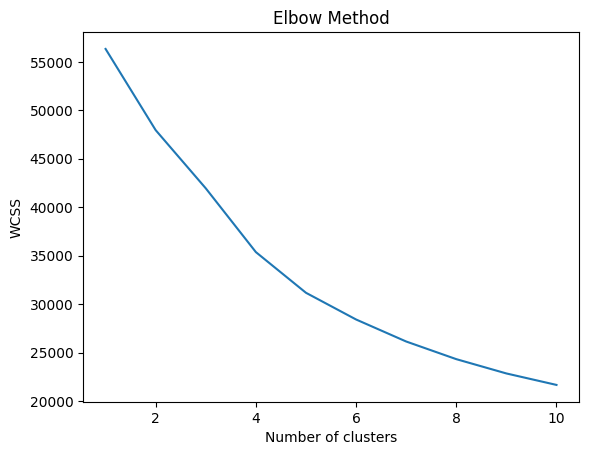

In [196]:
wcss = []
for i in range(1, 11):   #clusters 1-10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Kode ini digunakan untuk menentukan jumlah cluster yang optimal dalam algoritma K-Means dengan menggunakan metode Elbow Method.

Grafik Elbow Method menampilkan hubungan antara jumlah cluster dan nilai WCSS. Pada awalnya, nilai WCSS akan turun secara signifikan seiring bertambahnya jumlah cluster, karena data dibagi menjadi kelompok yang lebih kecil. Namun, pada titik tertentu penurunan WCSS mulai melambat dan membentuk sudut seperti siku (elbow). Titik inilah yang dianggap sebagai jumlah cluster terbaik, karena penambahan cluster setelah titik tersebut tidak memberikan peningkatan kualitas clustering yang signifikan. Jumlah cluster yang dipilih pada titik elbow ini akan digunakan pada tahap K-Means selanjutnya untuk menghasilkan pengelompokan negara yang optimal berdasarkan karakteristik data retail.

In [197]:
# Create a DataFrame to display the WCSS values for each number of clusters
wcss_table = pd.DataFrame({
    "Number of Clusters": range(1, 11),
    "WCSS": wcss
})

# Display the table
print(wcss_table)

   Number of Clusters          WCSS
0                   1  56329.000000
1                   2  47953.280882
2                   3  41952.994240
3                   4  35376.613690
4                   5  31181.716479
5                   6  28428.335203
6                   7  26158.100255
7                   8  24338.691793
8                   9  22864.081609
9                  10  21681.223915


Kode ini digunakan untuk menyajikan nilai WCSS dalam bentuk tabel agar hasil dari Elbow Method lebih mudah dibaca dan dianalisis.

Dari tabel terlihat bahwa nilai WCSS mengalami penurunan yang cukup besar dari 1 hingga sekitar 4 atau 5 cluster. Setelah itu, penurunan WCSS mulai melambat dan menjadi lebih kecil. Hal ini menunjukkan bahwa penambahan cluster setelah titik tersebut tidak memberikan peningkatan kualitas clustering yang signifikan. Berdasarkan pola ini, jumlah cluster yang paling masuk akal berada di sekitar 4 hingga 6 cluster, karena pada rentang tersebut keseimbangan antara kompleksitas model dan kualitas pengelompokan data sudah tercapai.

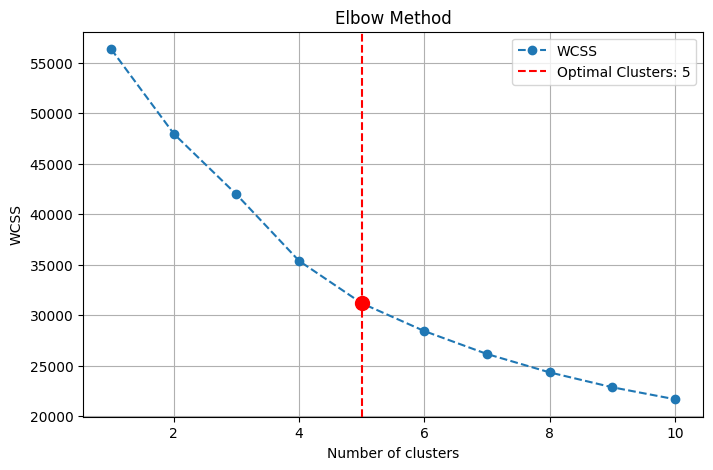

The optimal number of clusters is: 5


In [198]:
# Example WCSS values and cluster numbers
clusters = range(1, 11)

# Automatically find the elbow point using the KneeLocator
knee_locator = KneeLocator(clusters, wcss, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.knee

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(clusters, wcss, marker='o', linestyle='--', label="WCSS")
plt.axvline(optimal_clusters, linestyle='--', color='red', label=f'Optimal Clusters: {optimal_clusters}')
plt.scatter(optimal_clusters, wcss[optimal_clusters-1], c='red', s=100, zorder=5)  # Highlight elbow point
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_clusters}")

Kode ini digunakan untuk menentukan jumlah cluster optimal secara otomatis dengan menggunakan metode Elbow Method. Pada kode ini, nilai WCSS yang telah dihitung sebelumnya digunakan bersama dengan jumlah cluster dari 1 hingga 10. Grafik kemudian ditampilkan dengan garis vertikal merah yang menunjukkan jumlah cluster optimal, serta titik siku yang disorot agar mudah diidentifikasi.

Berdasarkan hasil perhitungan otomatis, jumlah cluster optimal yang diperoleh adalah 5 cluster. Artinya, pengelompokan data retail menjadi 5 kelompok sudah memberikan keseimbangan terbaik antara kualitas clustering dan kompleksitas model.

In [199]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        max_iter=300,
        n_init=10,
        random_state=42
    )

    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)


Kode ini digunakan untuk mengevaluasi kualitas hasil clustering K-Means dengan menggunakan Silhouette Score. Silhouette Score mengukur seberapa baik setiap data ditempatkan di dalam cluster-nya dibandingkan dengan cluster lain. Nilai Silhouette berada pada rentang -1 hingga 1, di mana nilai yang semakin mendekati 1 menunjukkan bahwa cluster semakin jelas dan terpisah dengan baik.

Nilai Silhouette Score yang dihasilkan menunjukkan seberapa optimal jumlah cluster yang digunakan. Jumlah cluster dengan nilai Silhouette Score tertinggi dianggap sebagai jumlah cluster terbaik, karena menunjukkan bahwa data dalam satu cluster memiliki kemiripan yang tinggi dan perbedaan yang jelas dengan cluster lainnya.

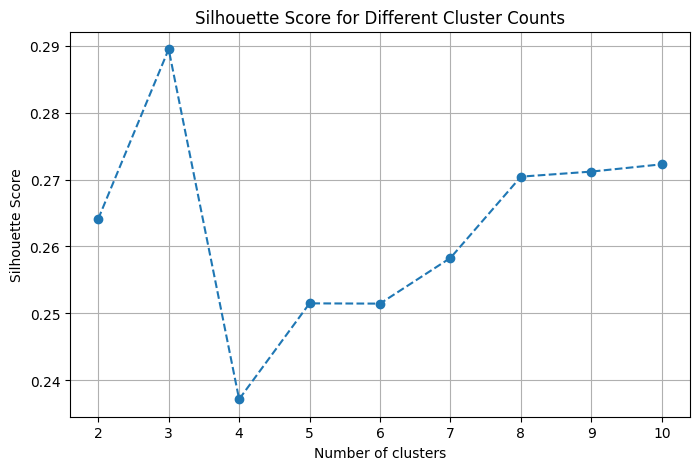

In [200]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Different Cluster Counts')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Grafik ini menunjukkan nilai silhouette score untuk jumlah cluster dari 2 sampai 10.
Dari hasil tersebut, nilai tertinggi muncul pada 3 cluster dengan skor sekitar 0,29, yang menandakan pemisahan cluster paling baik secara kualitas.
Namun, beberapa jumlah cluster lain seperti 8 dan 10 juga menunjukkan skor yang cukup tinggi, meskipun tidak signifikan lebih baik.
Berdasarkan hasil ini, 3 cluster memberikan kualitas clustering terbaik, sementara jumlah cluster yang lebih besar digunakan jika dibutuhkan segmentasi yang lebih detail.

In [201]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# -------------------------------
# 1. Silhouette Score for KMEANS
# -------------------------------

kmeans_scores = {}

for k in range(2, 11):   # silhouette cannot be computed for k=1
    km = KMeans(n_clusters=k, init="k-means++", random_state=0)
    labels = km.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    kmeans_scores[k] = score
    print(f"KMeans | k={k} → Silhouette Score: {score:.4f}")

# Find best k based on silhouette
best_k_kmeans = max(kmeans_scores, key=kmeans_scores.get)
print("\nBest K for KMeans based on Silhouette Score:", best_k_kmeans)


# ---------------------------------------------
# 2. Silhouette Score for HIERARCHICAL MODEL
# ---------------------------------------------

hier_scores = {}

for k in range(2, 11):
    hc = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    labels = hc.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    hier_scores[k] = score
    print(f"Hierarchical | k={k} → Silhouette Score: {score:.4f}")

# Best k for hierarchical
best_k_hier = max(hier_scores, key=hier_scores.get)
print("\nBest K for Hierarchical Clustering:", best_k_hier)


# ---------------------------------------------------
# 3. Compare Both Models (Summary Table)
# ---------------------------------------------------
comparison_df = pd.DataFrame({
    "K": range(2, 11),
    "KMeans Silhouette": [kmeans_scores[k] for k in range(2, 11)],
    "Hierarchical Silhouette": [hier_scores[k] for k in range(2, 11)]
})

print("\n=== Silhouette Score Comparison ===")
print(comparison_df)


KMeans | k=2 → Silhouette Score: 0.2183
KMeans | k=3 → Silhouette Score: 0.2330
KMeans | k=4 → Silhouette Score: 0.2560
KMeans | k=5 → Silhouette Score: 0.2515
KMeans | k=6 → Silhouette Score: 0.2515
KMeans | k=7 → Silhouette Score: 0.2627
KMeans | k=8 → Silhouette Score: 0.2626
KMeans | k=9 → Silhouette Score: 0.2710
KMeans | k=10 → Silhouette Score: 0.2546

Best K for KMeans based on Silhouette Score: 9
Hierarchical | k=2 → Silhouette Score: 0.2575
Hierarchical | k=3 → Silhouette Score: 0.2795
Hierarchical | k=4 → Silhouette Score: 0.2446
Hierarchical | k=5 → Silhouette Score: 0.2195
Hierarchical | k=6 → Silhouette Score: 0.2411
Hierarchical | k=7 → Silhouette Score: 0.2419
Hierarchical | k=8 → Silhouette Score: 0.2483
Hierarchical | k=9 → Silhouette Score: 0.2401
Hierarchical | k=10 → Silhouette Score: 0.2416

Best K for Hierarchical Clustering: 3

=== Silhouette Score Comparison ===
    K  KMeans Silhouette  Hierarchical Silhouette
0   2           0.218262                 0.257528


Kode ini digunakan untuk membandingkan performa dua metode clustering, yaitu K-Means dan Agglomerative Hierarchical Clustering, dengan menggunakan Silhouette Score sebagai metrik evaluasi. Silhouette Score mengukur seberapa baik data dikelompokkan di dalam cluster-nya, dengan nilai antara -1 hingga 1. Semakin tinggi nilainya, semakin baik kualitas cluster yang dihasilkan.

Berdasarkan hasil evaluasi, metode K-Means menghasilkan Silhouette Score tertinggi pada k = 9 dengan nilai sekitar 0,271, sedangkan metode Hierarchical Clustering menghasilkan Silhouette Score tertinggi pada k = 3 dengan nilai sekitar 0,279. Nilai ini menunjukkan bahwa secara keseluruhan Hierarchical Clustering memiliki kualitas pengelompokan yang lebih baik dibandingkan K-Means, karena menghasilkan Silhouette Score yang lebih tinggi dan cluster yang lebih jelas meskipun dengan jumlah cluster yang lebih sedikit. Hal ini menunjukkan bahwa pola data retail antar negara lebih mudah dipisahkan menjadi beberapa kelompok besar dibandingkan banyak cluster kecil. Oleh karena itu, Hierarchical Clustering dengan 3 cluster dipilih sebagai model terbaik karena memberikan hasil yang lebih stabil, mudah diinterpretasikan, dan memiliki pemisahan antar cluster yang lebih kuat.

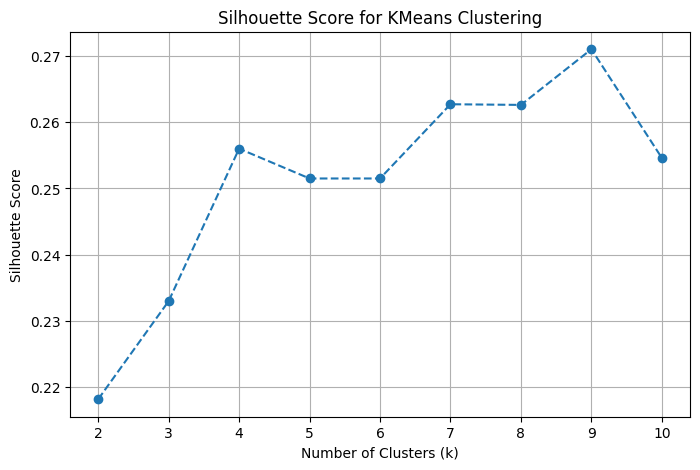

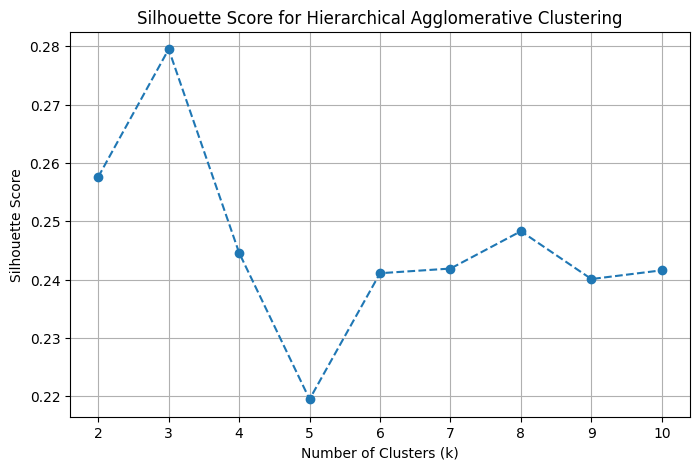

In [202]:
import matplotlib.pyplot as plt

# ============================
# Silhouette Scores (Your Data)
# ============================

k_values = [2,3,4,5,6,7,8,9,10]

kmeans_scores = [
    0.2182,
    0.2330,
    0.2560,
    0.2515,
    0.2515,
    0.2627,
    0.2626,
    0.2710,
    0.2546
]

hierarchical_scores = [
    0.2576,
    0.2795,
    0.2446,
    0.2195,
    0.2411,
    0.2419,
    0.2483,
    0.2401,
    0.2416
]


# ============================
# Plot 1: KMeans Silhouette Plot
# ============================

plt.figure(figsize=(8,5))
plt.plot(k_values, kmeans_scores, marker='o', linestyle='--')
plt.title("Silhouette Score for KMeans Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


# ============================
# Plot 2: Hierarchical Silhouette Plot
# ============================

plt.figure(figsize=(8,5))
plt.plot(k_values, hierarchical_scores, marker='o', linestyle='--')
plt.title("Silhouette Score for Hierarchical Agglomerative Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


Kode di atas digunakan untuk memvisualisasikan nilai Silhouette Score pada dua metode clustering, yaitu K-Means dan Hierarchical Agglomerative Clustering, dengan jumlah cluster (k) yang bervariasi dari 2 hingga 10. Semakin tinggi nilai Silhouette Score, semakin baik kualitas cluster yang terbentuk karena objek dalam satu cluster lebih mirip satu sama lain dan lebih berbeda dari cluster lainnya.

Pada grafik pertama, yang merepresentasikan metode K-Means, terlihat bahwa nilai Silhouette Score meningkat secara bertahap dan mencapai nilai tertinggi pada k = 9, yaitu sekitar 0,271. Hal ini menunjukkan bahwa pembagian data ke dalam sembilan cluster memberikan struktur pengelompokan terbaik untuk metode K-Means dibandingkan jumlah cluster lainnya.

Pada grafik kedua, yang menunjukkan hasil dari Hierarchical Agglomerative Clustering, nilai Silhouette Score tertinggi diperoleh pada k = 3, yaitu sekitar 0,279. Setelah k = 3, nilai Silhouette Score cenderung menurun, yang mengindikasikan bahwa penambahan jumlah cluster justru mengurangi kualitas pemisahan data.

Berdasarkan kedua grafik tersebut, dapat disimpulkan bahwa jumlah cluster optimal berbeda untuk setiap metode. Metode K-Means bekerja paling baik dengan 9 cluster, sedangkan Hierarchical Agglomerative Clustering memberikan hasil terbaik dengan 3 cluster. Jika dibandingkan secara keseluruhan, metode hierarchical memiliki nilai Silhouette Score maksimum yang sedikit lebih tinggi, sehingga dapat dikatakan bahwa Hierarchical Agglomerative Clustering menghasilkan kualitas pengelompokan yang lebih baik dan lebih mudah diinterpretasikan pada dataset ini.

#Fit Clustering Models & Add Cluster Labels

In [203]:
from sklearn.cluster import KMeans, AgglomerativeClustering

# KMeans best model
kmeans = KMeans(n_clusters=9, random_state=0)
df["kmeans_cluster"] = kmeans.fit_predict(df_scaled)

# Hierarchical best model
hier = AgglomerativeClustering(n_clusters=3)
df["hier_cluster"] = hier.fit_predict(df_scaled)


Kode di atas digunakan untuk menerapkan model clustering terbaik berdasarkan hasil evaluasi sebelumnya menggunakan Silhouette Score.

Pada bagian pertama, model K-Means dibuat dengan n_clusters=9, yang berarti data akan dikelompokkan ke dalam sembilan cluster. Hasil pengelompokan tersebut kemudian disimpan ke dalam kolom baru bernama kmeans_cluster pada DataFrame df.

Pada bagian kedua, metode Hierarchical Agglomerative Clustering diterapkan dengan n_clusters=3. Metode ini mengelompokkan data secara bertahap berdasarkan jarak antar data hingga terbentuk tiga cluster utama. Label hasil clustering disimpan ke dalam kolom baru bernama hier_cluster.

# Cluster Summary

In [204]:
kmeans_summary = df.groupby("kmeans_cluster")[features].mean()
hier_summary = df.groupby("hier_cluster")[features].mean()

print("=== KMeans Cluster Summary ===")
print(kmeans_summary)

print("\n=== Hierarchical Cluster Summary ===")
print(hier_summary)


=== KMeans Cluster Summary ===
                      Sales       Profit  Quantity  Discount    Country  \
kmeans_cluster                                                            
0                324.221140    54.219750  8.013908  0.043672   6.105702   
1                188.642602    36.146168  3.318182  0.039840   6.744207   
2                139.239259    27.597304  2.930076  0.027591   4.527801   
3                186.666193    40.181818  3.182528  0.026065  12.966619   
4               3306.400000  1147.000000  7.433333  0.031667   9.000000   
5               1632.138365   344.201258  5.716981  0.059748   6.965409   
6                153.368337   -68.638823  3.550517  0.493317   8.254574   
7                428.383037    64.805746  3.177839  0.074419   5.381669   
8               1499.896552  -935.896552  6.586207  0.498276   7.362069   

                Category  Ship Mode  
kmeans_cluster                       
0               0.912378   0.482615  
1               0.992870   2.

#Barplot Visualization for Each Cluster

## KMeans Barplot

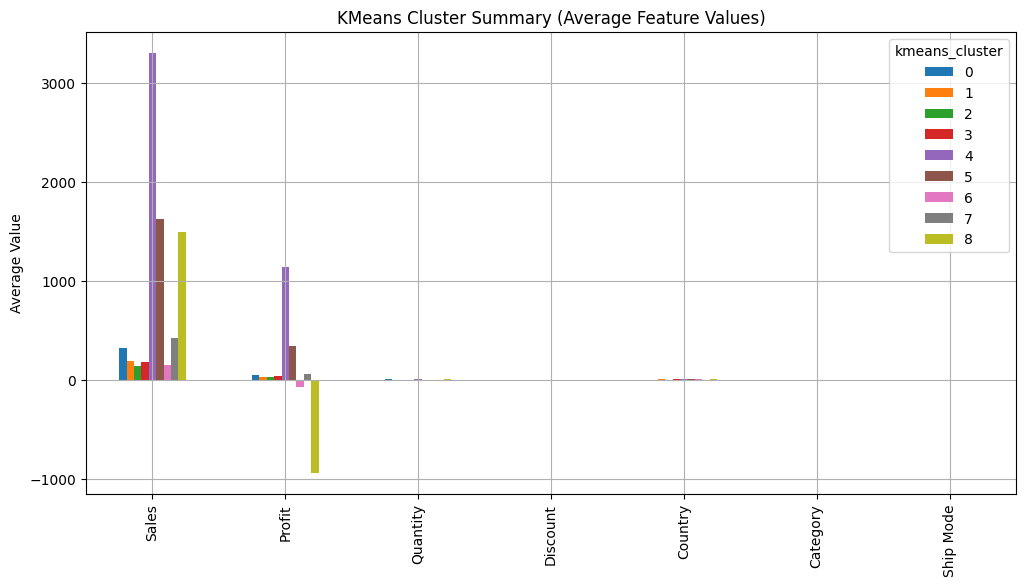

In [205]:
import matplotlib.pyplot as plt

kmeans_summary.T.plot(kind='bar', figsize=(12,6))
plt.title("KMeans Cluster Summary (Average Feature Values)")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()


## Hierarchical Agglomerative Barplot

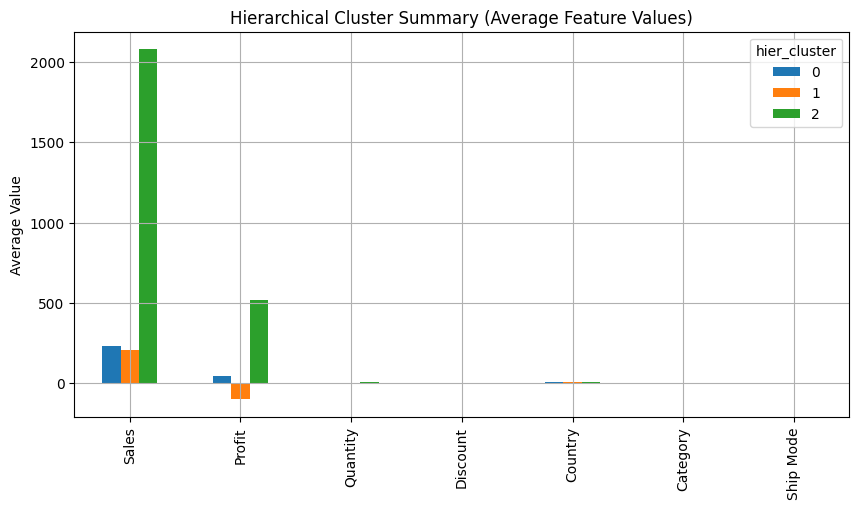

In [206]:
hier_summary.T.plot(kind='bar', figsize=(10,5))
plt.title("Hierarchical Cluster Summary (Average Feature Values)")
plt.ylabel("Average Value")
plt.grid(True)
plt.show()


# World Map Visualization for Clusters

##KMeans World Map

In [207]:
import plotly.express as px

fig = px.choropleth(
    df,
    locations="ISO3",
    color="kmeans_cluster",
    hover_name="Country",
    title="World Map: KMeans Clusters",
    color_continuous_scale="Viridis"
)
fig.show()


## Hierarchical Agglomerative Clustering World Map

In [208]:
fig = px.choropleth(
    df,
    locations="ISO3",
    color="hier_cluster",
    hover_name="Country",
    title="World Map: Hierarchical Clustering",
    color_continuous_scale="Plasma"
)
fig.show()


#KMEANS CLUSTER PROFILING & POLICY RECOMMENDATIONS (k = 9)

# Cluster 0 - Stable Mid-Value Markets

###Cluster Profiling:
*   Countries in Cluster 0 exhibit moderate sales (≈324) and stable profit levels (≈54), supported by medium order quantities and consistently low discounts. This indicates efficient pricing strategies and good cost control, where revenue generation is not dependent on aggressive promotions. The category average (~0.91) suggests that demand is concentrated in Furniture and Office Supplies, which are functional products with predictable purchasing cycles. Shipping behavior is balanced and leans toward Economy modes, implying that customers prioritize cost efficiency over delivery speed. Overall, this cluster represents mature and reliable markets with low volatility and steady demand patterns.

### Policy Recommendation:
*  Businesses should maintain the current pricing and logistics strategies in these countries, as they already produce sustainable profits. Instead of pursuing aggressive expansion or heavy discounting, the focus should be on increasing average order value through bundling and cross-category promotions. Strengthening customer retention programs and loyalty initiatives will help maximize lifetime value while preserving margins, making these markets ideal for long-term, stable growth.

#Cluster 1 – Low-Volume, Low-Risk Countries
###Cluster Profiling:
*   Cluster 1 countries show relatively low sales and profit, driven by small order quantities rather than weak demand. Discounts are minimal, indicating disciplined pricing, but the high ship mode value (~2.8) reveals frequent use of Priority shipping, which significantly increases fulfillment costs. The dominance of Office Supplies (category ≈0.99), a low-margin product category, further limits profitability when paired with premium logistics. Despite these challenges, profits remain positive, indicating low financial risk but inefficient cost structures.
### Policy Recommendation:
*   The strategic focus for this cluster should be on cost-efficiency optimization rather than revenue expansion. Businesses should encourage the use of Economy or Economy Plus shipping through incentives and introduce minimum order thresholds for Priority delivery. Promoting bulk purchases of Office Supplies can also help improve per-order profitability without requiring additional marketing investment.

#Cluster 2 – Small Orders, Conservative Buyers

###Cluster Profiling:
*   Countries in Cluster 2 are characterized by low sales and profit, very small order quantities, and the lowest discount levels across all clusters. This combination suggests cautious and infrequent purchasing behavior rather than operational inefficiencies. The category mix is heavily skewed toward Furniture, which typically involves higher prices and longer decision-making processes. Conservative shipping usage further reflects risk-averse consumers who prioritize careful spending over convenience or speed.

### Policy Recommendation:
*   To unlock demand in this cluster, businesses should focus on reducing perceived risk and encouraging trial purchases. Limited-time introductory discounts, first-time buyer promotions, and strong trust-building measures such as warranties, return policies, and customer testimonials can help increase purchase frequency. The objective is to build confidence and gradually stimulate demand without relying on heavy, long-term discounting.

#Cluster 3 – High Logistics Cost Markets

###Cluster Profiling:
*   Cluster 3 countries show moderate sales and profit but stand out due to a very high average country value (~12.97) and frequent use of Priority or Immediate shipping. These patterns indicate geographically distant or logistically complex markets where delivery costs are inherently high. Demand exists and is reasonably stable, but operational and transportation costs significantly impact scalability and margin sustainability.
### Policy Recommendation:
*   Profitability in this cluster depends on restructuring logistics rather than altering demand. Businesses should evaluate localized warehousing, partnerships with regional distributors, or third-party fulfillment services to reduce delivery costs. Implementing minimum order thresholds or delivery surcharges can help maintain profitability without substantially reducing customer demand.

#Cluster 4 – Premium High-Value Markets

###Cluster Profiling:
*   Cluster 4 is the strongest-performing segment, with extremely high sales (≈3306) and very high profit (≈1147). Customers in these countries place large orders, require limited discounting, and show a strong preference for Technology products (category ≈1.13), which generally carry higher margins. Shipping modes are well balanced, suggesting efficient infrastructure and mature logistics systems. These characteristics indicate high purchasing power and advanced retail ecosystems.

### Policy Recommendation:
*   These countries should be prioritized as strategic growth markets. Businesses should allocate more inventory, marketing resources, and innovation efforts to these regions, including early launches of new and premium products. Strengthening customer loyalty programs and long-term partnerships will help maximize lifetime value and sustain their high return on investment.

#Cluster 5 – High Sales with High Discounts

###Cluster Profiling:
*   Cluster 5 records high sales and strong profit performance, but this success is supported by above-average discount levels. The dominance of Technology products and customer responsiveness to promotions indicate relatively high price sensitivity and competitive market conditions. While profitability remains positive, the reliance on discounts introduces margin risk and may weaken long-term pricing power.

### Policy Recommendation:
*   The key objective in this cluster is to gradually reduce dependence on price-based promotions while maintaining sales volume. This can be achieved by shifting toward value-added services, bundled offerings, or subscription models that enhance perceived value without eroding margins. Careful monitoring of promotion effectiveness is essential to ensure sustainable profitability.

#Cluster 6 – Loss-Making Markets

###Cluster Profiling:
*   Cluster 6 is characterized by moderate sales but negative profit (≈ -68), indicating structural inefficiencies rather than lack of demand. High discount levels combined with low order quantities and inefficient logistics prevent revenue from translating into profit. The current operating model in these countries is financially unsustainable despite the presence of customer demand.

### Policy Recommendation:
*   Immediate corrective action is required to prevent further losses. Businesses should reduce excessive discounting, eliminate unprofitable product lines, and renegotiate shipping and fulfillment costs. If profitability cannot be restored after these adjustments, scaling down operations or exiting these markets should be considered.

#Cluster 7 – Logistics-Driven Buyers

###Cluster Profiling:
*   Countries in Cluster 7 show moderate-to-high sales and profit, but unusually high ship mode values, indicating frequent use of Immediate and Priority shipping. The dominance of Technology products (category ≈2.0) suggests that customers highly value fast delivery and convenience. These buyers are less sensitive to price but strongly influenced by service quality and delivery speed.

### Policy Recommendation:
*   Rather than absorbing high logistics costs, businesses should monetize customers’ willingness to pay for speed. Introducing express shipping surcharges, premium delivery tiers, or subscription-based fast shipping services can improve margins while maintaining customer satisfaction. Marketing efforts should emphasize reliability and delivery speed as key value propositions.

#Cluster 8 – Loss-Making Markets

###Cluster Profiling:
*   Cluster 8 generates very high sales (≈1500) but suffers severe losses (≈ -936) due to extremely high discount levels (~0.50). Although order volumes are relatively strong, aggressive pricing strategies eliminate profit, resulting in unsustainable revenue growth. This cluster represents a significant financial risk despite its apparent sales success.

### Policy Recommendation:
*   Urgent pricing reform is necessary to stabilize this cluster. Businesses should implement strict discount caps, approval mechanisms, and minimum margin thresholds to prevent further losses. Shifting the product mix toward higher-margin items and reducing promotional intensity are critical steps to restore profitability and reduce financial risk.




#AGGLOMERATIVE HIERARCHICAL CLUSTER PROFILING (k = 3)

# Cluster 0 – Balanced & Profitable Markets

###Cluster Profiling:
*   Countries in Cluster 0 exhibit moderate sales accompanied by strong and stable profit levels, indicating a healthy balance between revenue generation and cost control. Discount usage is low, suggesting that customer demand is not heavily driven by price promotions, while order quantities remain consistent, reflecting predictable purchasing behavior. The category mix is well distributed across Furniture, Office Supplies, and Technology, reducing dependency on a single product segment. In addition, the dominance of Economy shipping modes indicates efficient logistics management and cost-conscious customers, contributing to sustainable profitability and low operational risk.

### Policy Recommendation:
*  Businesses should maintain steady and conservative growth strategies in these markets, as their performance supports reliable revenue forecasting and long-term planning. The focus should be on customer retention, operational efficiency, and incremental improvements rather than aggressive expansion or discount-driven growth. These markets are well suited for long-term investment and stable portfolio performance.


#Cluster 1 – High Discount, Low Profit Markets
###Cluster Profiling:
*   Cluster 1 countries display moderate sales levels but suffer from negative profitability, primarily due to extremely high discount rates (≈0.48). Although customer demand exists, excessive reliance on promotions significantly erodes margins and undermines financial sustainability. This pattern suggests weak pricing discipline and possible inefficiencies in cost management, where revenue growth fails to translate into profit due to aggressive discounting strategies.
### Policy Recommendation:
*   The primary objective in this cluster should be margin recovery. Businesses must reduce promotional intensity, introduce stricter discount controls, and adopt more disciplined pricing strategies. Improving shipping efficiency and aligning logistics costs with order value can further support profitability. Without corrective action, continued operations in these markets pose a financial risk.

#Cluster 2 – High-Value Strategic Markets
###Cluster Profiling:
*   Cluster 2 represents high-performing countries with very high sales (≈2079) and strong profit levels (≈516), supported by larger order sizes and controlled discounting. Technology products dominate the category mix, indicating demand for high-value items with better margins. Customers in these markets exhibit strong purchasing power and consistent buying behavior, supported by efficient logistics and mature retail infrastructure, making this cluster a key driver of overall business performance.
### Policy Recommendation:
*   These countries should be treated as core strategic markets and prioritized for investment and expansion. Businesses should allocate more resources to marketing, innovation, and inventory availability, while strengthening customer loyalty programs and strategic partnerships. Focusing on long-term customer lifetime value and premium offerings will help sustain growth and maximize returns from these high-value markets.